choose what model to predict with inot modelnum
1 --> predict with Xgboost, 2 --> predict with Random Forest and 3 --> predict with ranknet

In [1]:
modelNum = 3

In [2]:
import os
import asyncio
from sklearn.experimental import enable_iterative_imputer        # noqa: F401
from sklearn.impute import IterativeImputer

from Data_processing_and_inputting.historical_data_pipeline import ProcessIracingHistoicalData
from Data_processing_and_inputting.live_data_pipeline import ProcessIracingLiveData, run_in_background
from model.FetchDatabaseData import process_all_races
from model.Ranknet.Train import RankNet

from utils.DatabaseConnection import execute_query, set_database
from utils.NormTarget import normalize_group
from joblib import load
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import numpy as np


def deletedata() -> None:
    """Reset all live-race tables so every run starts clean."""
    set_database("racing_data_Live")

    execute_query("DELETE FROM RealTimeEvents;")
    execute_query("DELETE FROM RealTimeLapData;")
    execute_query("DELETE FROM PastRaceTable;")
    execute_query("DELETE FROM Driver;")
    execute_query("DELETE FROM Race;")

    execute_query("DBCC CHECKIDENT ('Race', RESEED, 0);")
    execute_query("DBCC CHECKIDENT ('RealTimeEvents', RESEED, 0);")


async def start_pipeline(model_num: int):
    """
    • Loads the requested model  
    • Pulls historical data  
    • Launches the live-data coroutine **on the notebook’s event loop**  
    Returns: (live_task, race_id, model, scaler, imputer, device)
    """
    set_database("racing_data_Live")
    deletedata()

    script_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    scaler = imputer = model = None
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model_num == 1:
        model_path = os.path.join(script_dir, "predicting-the-top3-drivers-and-comparing-machine-learning-algorithms-in-iracing/model/XGboost/Saved_models/best_xgboost_model_rank.joblib")
        scaler_path = os.path.join(script_dir, "predicting-the-top3-drivers-and-comparing-machine-learning-algorithms-in-iracing/model/XGboost/Saved_models/xgboost_scaler.joblib")
        imputer_path = os.path.join(script_dir, "predicting-the-top3-drivers-and-comparing-machine-learning-algorithms-in-iracing/model/XGboost/Saved_models/xgboost_imputer.joblib")

        model   = load(model_path)
        scaler  = load(scaler_path)
        imputer = load(imputer_path)

        print("Gathering historical data first before prediction …")
        race_id = await ProcessIracingHistoicalData(False)
        print("\n\nStarting live data feed …\n")
        print("Historical data fetched. You may start the prediction now.")
        return  race_id, model, scaler, imputer, device

    elif model_num == 2:
        model_path = os.path.join(script_dir, "predicting-the-top3-drivers-and-comparing-machine-learning-algorithms-in-iracing/model/RandomForest/Saved_models/best_random_forest_model.joblib")
        scaler_path = os.path.join(script_dir, "predicting-the-top3-drivers-and-comparing-machine-learning-algorithms-in-iracing/model/RandomForest/Saved_models/random_forest_scaler.joblib")
        imputer_path = os.path.join(script_dir, "predicting-the-top3-drivers-and-comparing-machine-learning-algorithms-in-iracing/model/RandomForest/Saved_models/random_forest_imputer.joblib")

        model   = load(model_path)
        scaler  = load(scaler_path)
        imputer = load(imputer_path)

        print("Gathering historical data first before prediction …")
        race_id = await ProcessIracingHistoicalData(False)
        print("\n\nStarting live data feed …\n")
        print("Historical data fetched. You may start the prediction now.")
        return  race_id, model, scaler, imputer, device

    elif model_num == 3:
        model_path   = os.path.join(script_dir, "predicting-the-top3-drivers-and-comparing-machine-learning-algorithms-in-iracing/model/Ranknet/Saved_models/best_Rank_Net_model.pth")
        scaler_path  = os.path.join(script_dir, "predicting-the-top3-drivers-and-comparing-machine-learning-algorithms-in-iracing/model/Ranknet/Saved_models/Rank_Net_scaler.joblib")
        imputer_path = os.path.join(script_dir, "predicting-the-top3-drivers-and-comparing-machine-learning-algorithms-in-iracing/model/Ranknet/Saved_models/Rank_Net_imputer.joblib")

        scaler  = load(scaler_path)
        imputer = load(imputer_path)

        input_dim = len(scaler.feature_names_in_)
        model = RankNet(input_dim=input_dim).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()

        print("Gathering historical data first before prediction …")
        race_id = await ProcessIracingHistoicalData(True)
        print("\n\nStarting live data feed …\n")
        # live_task = asyncio.create_task(ProcessIracingLiveData(race_id, True, None))
        print("Historical data fetched. You may start the prediction now.")
        return  race_id, model, scaler, imputer, device

    else:
        raise ValueError("model_num must be 1, 2, or 3")


iRacing API client initialized successfully.


C:\Users\Anthr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


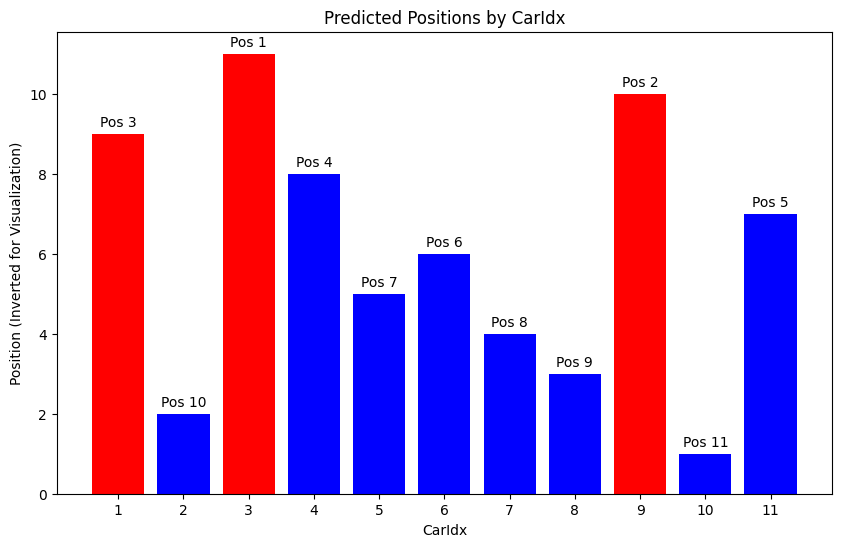

▸ Processing race 1


C:\Users\Anthr\AppData\Local\Temp\ipykernel_5196\1030777350.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace('Missing', 0, inplace=True)


In [ ]:

race_id, Model, Scaler, imputer, device = await start_pipeline(modelNum)
# asyncio.get_event_loop().create_task(
#     ProcessIracingLiveData(race_id, True, None)
# )
run_in_background(ProcessIracingLiveData(race_id, True, None))
print("\n\n")

inputNumber = int(input("press 1 to adondon the prediction or press 2 to start the prediction"))


if inputNumber == 1:
    deletedata()
    exit()
else:

    try:
        while True:
             
            data = process_all_races(True, True)
            data = normalize_group(data)

        
            # Replace any string 'Missing' with 0 in the entire DataFrame, and explicitly infer objects to avoid FutureWarning
            data.replace('Missing', 0, inplace=True)
            data = data.infer_objects(copy=False)

            data['RankScoreAdjusted_norm'] = data['RankScoreAdjusted_norm'].fillna(0)
            data['Drv_RankScoreAdjusted'] = data['Drv_RankScoreAdjusted'].fillna(0)

            logical_suffixes = ["_incident", "_inpits", "_offtrack", '_inpits_']
            incident_cols = []
            for col in data.columns:
                if any(col.endswith(suf) for suf in logical_suffixes):
                    incident_cols.append(col)
            
            data[incident_cols] = data[incident_cols].fillna(0)

            features = data.columns.tolist()
            
            # if modelNum == 2 or 1:
            #     drop_cols =  [c for c in features if "NormDriverGapToLeader" in c]
            #     features = [c for c in features if c not in drop_cols]

            features.remove('RaceID')
            features.remove('CarIdx')
            features.remove('Drv_RankScoreAdjusted')
            features.remove('RankScoreAdjusted_norm')
            features.remove('Race_RaceDate')

            # Use scaler's feature names for alignment
            model_features = Scaler.feature_names_in_
            # Fill missing values with a constant before imputation
            data.fillna(0, inplace=True)
            # model_features is Scaler.feature_names_in_
            X = data.reindex(columns=model_features, fill_value=0)

            X_scaled = Scaler.transform(X)
            X_train_imputed = imputer.fit_transform(X_scaled)

            if modelNum != 3:
                predictions = Model.predict(X_train_imputed)
            else:
                with torch.no_grad():
                    X_tensor = torch.from_numpy(X_train_imputed).to(device, dtype=torch.float32)
                    print("Loaded model architecture:", Model)
                    print("Input features count:", len(Scaler.feature_names_in_))
                    y_pred = Model(X_tensor)
                    predictions = y_pred.cpu().numpy().ravel()
            # Add predictions and predicted position to the DataFrame
            data['Prediction_Value'] = predictions
            data['Position_Predicted'] = data['Prediction_Value'].rank(ascending=False).astype(int)

            # For visualization, invert positions so 1st=highest bar 
            total_participants = len(data)
            data['Inverted_Position'] = total_participants - data['Position_Predicted'] + 1

            clear_output(wait=True)

            plt.figure(figsize=(10, 6))
            # Plot bars without sorting CarIdx
            bars = plt.bar(data['CarIdx'], data['Inverted_Position'],
                        color=['red' if pos <= 3 else 'blue' for pos in data['Position_Predicted']])

            # Add labels (actual positions: 1st, 2nd, 3rd...)
            for idx, bar in enumerate(bars):
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1,
                        f"Pos {data.iloc[idx]['Position_Predicted']}",
                        ha='center', va='bottom')

            plt.xlabel('CarIdx')
            plt.ylabel('Position (Inverted for Visualization)')
            plt.title('Predicted Positions by CarIdx')
            plt.xticks(data['CarIdx'])
            plt.show()

            
            plt.pause(0.1)  # Pause for 10 seconds before refreshing the plot
    except RuntimeError as e:
        print("Stopping prediction ", e)
        deletedata()
        exit()
    except ValueError as e:
        print("Feature mismatch: ", e)
        deletedata()
        exit()